In [16]:
#Some useful packages

import pandas as pd
import numpy as np
import operator
import matplotlib.pylab as plt

In [92]:
#Load data and data reduction and data cleaning

df = pd.read_csv('liquors.csv')
df.drop(['Store Location', 'Invoice/Item Number', 'Store Name', 'Address', 'City', 'Volume Sold (Gallons)', 'Zip Code'], axis=1, inplace=True)
df.drop(df.index[:10708015], inplace=True)
df.dropna(inplace=True)
df['State Bottle Retail'] = df['State Bottle Retail'].map(lambda x: x.lstrip('$'))
df['State Bottle Retail'] = df['State Bottle Retail'].map(lambda x: float(x))
df['Sale (Dollars)'] = df['Sale (Dollars)'].map(lambda x: x.lstrip('$'))
df['Sale (Dollars)'] = df['Sale (Dollars)'].map(lambda x: float(x))
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Date,Store Number,County Number,County,Category,Category Name,Vendor Number,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters)
10708015,01/03/2017,4312,78.0,POTTAWATTA,1012200.0,Scotch Whiskies,55.0,SAZERAC NORTH AMERICA,8208,House Of Stuart,6,1750,$10.52,15.78,3,15.78,5.25
10708016,01/03/2017,4312,78.0,POTTAWATTA,1042100.0,Imported Dry Gins,35.0,BACARDI USA INC,28206,Bombay Dry Gin,12,750,$10.50,15.75,1,189.00,0.75
10708017,01/03/2017,4312,78.0,POTTAWATTA,1082000.0,Imported Cordials & Liqueurs,259.0,Heaven Hill Brands,65195,Hpnotiq,6,750,$9.83,14.75,1,88.50,0.75
10708018,01/03/2017,4312,78.0,POTTAWATTA,1081200.0,Cream Liqueurs,260.0,DIAGEO AMERICAS,68037,Bailey's Original Irish Cream,12,1000,$16.50,24.75,2,297.00,2.00
10708019,01/03/2017,4312,78.0,POTTAWATTA,1012100.0,Canadian Whiskies,65.0,Jim Beam Brands,10627,Canadian Club Whisky,12,1000,$9.71,14.57,1,174.84,1.00


In [3]:
# Navie Bayes Classifier, part one: Scan data set:

sale_category = {}
sale_item = {}
category_item = {}
category_volume = {}
csv = {}
sv = {}


for i, r in df.iterrows():
    
    category = r['Category']
    item = r['Item Number']
    price = r['State Bottle Retail']
    volume = r['Volume Sold (Liters)']
    store = r['Store Number']
    vendor = r['Vendor Number']
    bottle = r['Bottles Sold']
    
    if category in sale_category:
        sale_category[category] += price*bottle
    else:
        sale_category[category] = price*bottle
        
    if item in sale_item:
        sale_item[item] += price*bottle
    else:
        sale_item[item] = price*bottle
        
    if category in category_item:
        if item in category_item[category]:
            category_item[category][item] += volume
        else:
            category_item[category][item] = volume
    else:
        category_item[category] = {}
        category_item[category][item] = volume
    
    if category in category_volume:
        category_volume[category] += volume
    else:
        category_volume[category] = volume
        
    if (category, store, vendor) in csv:
        csv[(category, store, vendor)] += 1
    else:
        csv[(category, store, vendor)] = 1
        
    if (store, vendor) in sv:
        sv[(store, vendor)] += 1
    else:
        sv[(store, vendor)] = 1

In [4]:
county_sale = {}
county_pop = {}
county_vendorV = {}
county_vendorR = {}
vendor_county = {}


for i, r in df.iterrows():
    
    county = r['County Number']
    v = r['Volume Sold (Liters)']
    p = r['State Bottle Retail']
    vendor = r['Vendor Number']
    b = r['Bottles Sold']
    category = r['Category']
    
    if county in county_sale:
        if category in county_sale[county]:
            county_sale[county][category] += p*b
        else:
            county_sale[county][category] = p*b
    else:
        county_sale[county] = {}
        county_sale[county][category] = p*b
    
    if county in county_pop:
        if category in county_pop[county]:
            county_pop[county][category] += v
        else:
            county_pop[county][category] = v
    else:
        county_pop[county] = {}
        county_pop[county][category] = v
    
    if county in county_vendorV:
        if vendor in county_vendorV[county]:
            county_vendorV[county][vendor] += v
        else:
            county_vendorV[county][vendor] = v
    else:
        county_vendorV[county] = {}
        county_vendorV[county][vendor] = v
    
    if county in county_vendorR:
        if vendor in county_vendorR[county]:
            county_vendorR[county][vendor] += p*b
        else:
            county_vendorR[county][vendor] = p*b
    else:
        county_vendorR[county] = {}
        county_vendorR[county][vendor] = p*b
    
    if vendor in vendor_county:
        if county in vendor_county[vendor]:
            vendor_county[vendor][county] += p*b
        else:
            vendor_county[vendor][county] = p*b
    else:
        vendor_county[vendor] = {}
        vendor_county[vendor][county] = p*b

In [15]:
def bayes_model(store, vendor):
    P = {}
    for key, value in csv.items():
        c, s, v = key
        if s==store and v==vendor:
            P[c] = value/sv[s,v]
    if (len(P)):
        return max(P, key=P.get)
    return None

def vendor_sale_county(vendor):
    return max(vendor_county[vendor], key=vendor_county[vendor].get)

def county_revenue(county):
    return max(county_sale[county], key=county_sale[county].get)

def county_vendorv(county):
    return max(county_vendorV[county], key=county_vendorV[county].get)

def county_vendorr(county):
    return max(county_vendorR[county], key=county_vendorR[county].get)

def county_p(county):
    return max(county_pop[county], key=county_pop[county].get)

In [21]:
sorted_Csale = sorted(sale_category.items(), key=operator.itemgetter(1))
sorted_Isale = sorted(sale_item.items(), key=operator.itemgetter(1))
sorted_Cvolume = sorted(category_volume.items(), key=operator.itemgetter(1))

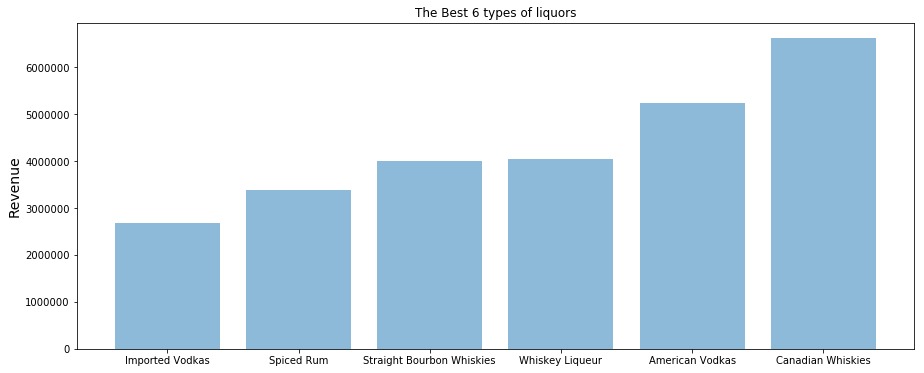

In [80]:
# Data visulization for category sale

x1, y1 = map(list, zip(*sorted_Csale))
csale6 = y1[len(y1)-6:]
numbers = x1[len(x1)-6:]
objects1 = []
for number in numbers:
    objects1.append(list(df.loc[df['Category'] == number, 'Category Name'])[0])
y_pos = np.arange(len(objects1))
plt.figure(figsize=(15, 6))
plt.bar(y_pos, csale6, align='center', alpha=0.5)
plt.xticks(y_pos, objects1)
plt.ylabel('Revenue', fontsize=14)
plt.title('The Best 6 types of liquors')
plt.show()

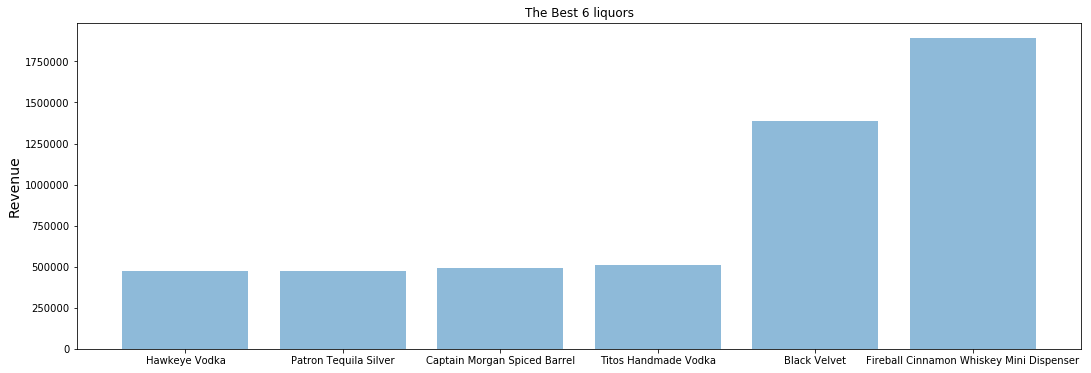

In [81]:
# Data visulization for item sales

x2, y2 = map(list, zip(*sorted_Isale))
isale6 = y2[len(y2)-6:]
numbers2 = x2[len(x2)-6:]
objects2 = []
for number in numbers2:
    objects2.append(list(df.loc[df['Item Number'] == number, 'Item Description'])[0])
y_pos = np.arange(len(objects2))
plt.figure(figsize=(18, 6))
plt.bar(y_pos,isale6, align='center', alpha=0.5)
plt.xticks(y_pos, objects2)
plt.ylabel('Revenue', fontsize=14)
plt.title('The Best 6 liquors')
plt.show()

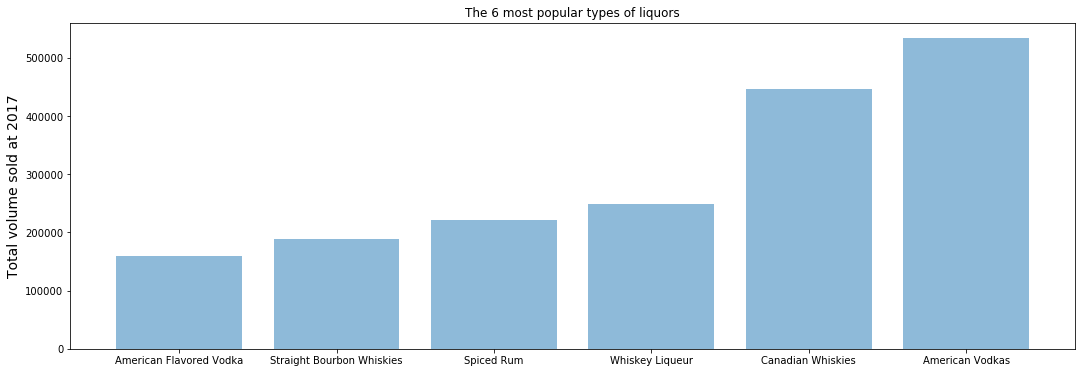

In [79]:
#Data Visulization for popular types of liquor

x3, y3 = map(list, zip(*sorted_Cvolume))
cvolume6 = y3[len(y3)-6:]
numbers3 = x3[len(x3)-6:]
objects3 = []
for number in numbers3:
    objects3.append(list(df.loc[df['Category'] == number, 'Category Name'])[0])
y_pos = np.arange(len(objects3))
plt.figure(figsize=(18, 6))
plt.bar(y_pos,cvolume6, align='center', alpha=0.5)
plt.xticks(y_pos, objects3)
plt.ylabel('Total volume sold at 2017', fontsize=14)
plt.title('The 6 most popular types of liquors')
plt.show()

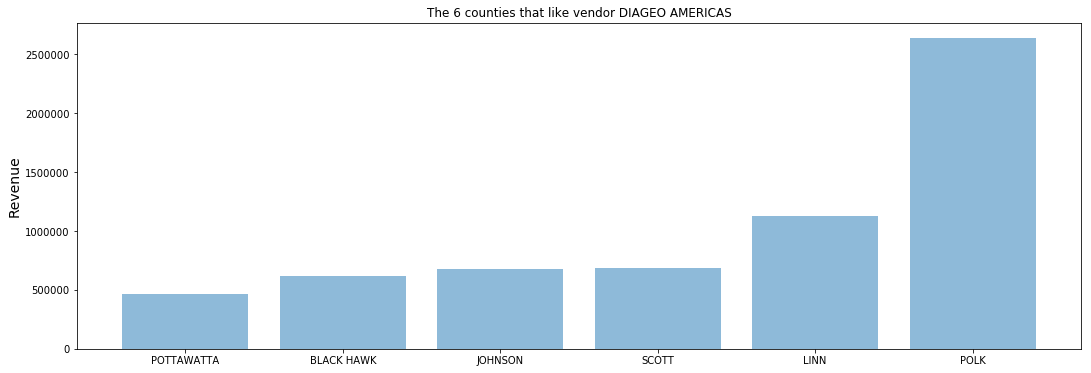

In [127]:
sorted_vendor = sorted(vendor_county[260].items(), key=operator.itemgetter(1))
x4, y4 = map(list, zip(*sorted_vendor))
vendorc6 = y4[len(y4)-6:]
numbers4 = x4[len(x4)-6:]
objects4 = []
for number in numbers4:
    objects4.append(list(df.loc[df['County Number'] == number, 'County'])[0])
y_pos = np.arange(len(objects4))
plt.figure(figsize=(18, 6))
plt.bar(y_pos,vendorc6, align='center', alpha=0.5)
plt.xticks(y_pos, objects4)
plt.ylabel('Revenue', fontsize=14)
plt.title('The 6 counties that like vendor DIAGEO AMERICAS')
plt.show()

In [135]:
# Bayesian Reasoning:

cates = {}

for i, r in df.iterrows():
    
    cate = r['Category']
    if cate in cates:
        cates[cate] += 1
    else:
        cates[cate] = 1

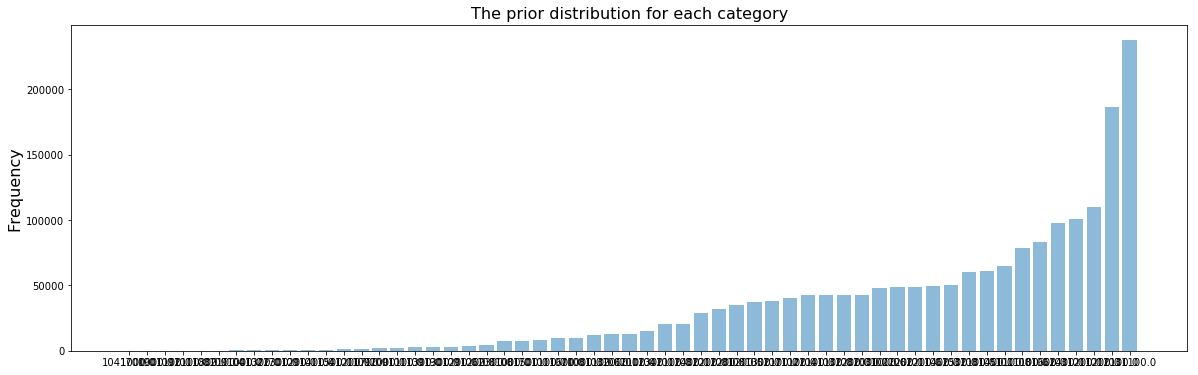

In [148]:
sorted_cates = sorted(cates.items(), key=operator.itemgetter(1))
x5, y5 = map(list, zip(*sorted_cates))
y_pos = np.arange(len(x5))
plt.figure(figsize=(20, 6))
plt.bar(y_pos, y5, align='center', alpha=0.5)
plt.xticks(y_pos, x5)
plt.ylabel('Frequency', fontsize=16)
plt.title('The prior distribution for each category', fontsize=16)
plt.show()

In [150]:
def bayes_reasoning(store, vendor):
    P = {}
    for key, value in csv.items():
        c, s, v = key
        if s==store and v==vendor:
            P[c] = value/sv[s,v]
    return P

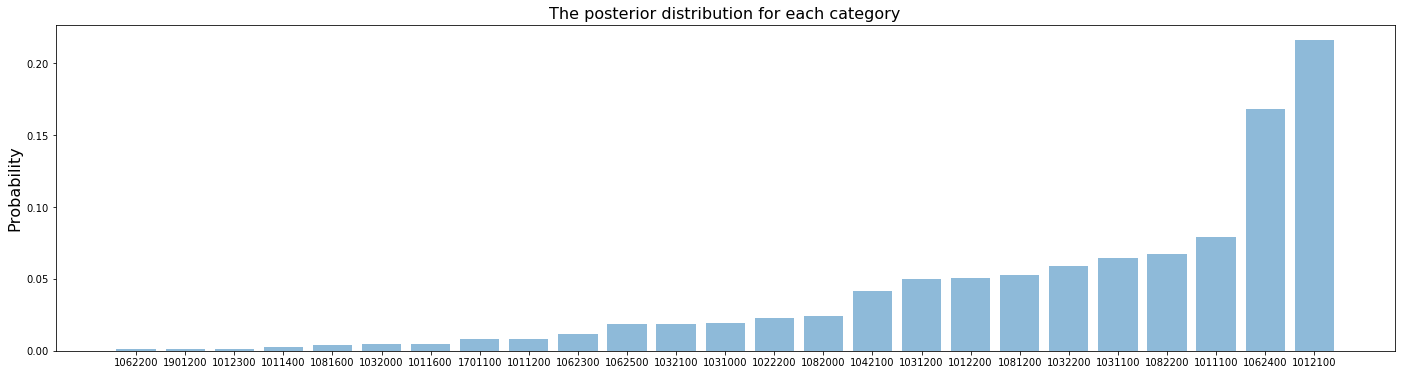

In [156]:
posterior = bayes_reasoning(4312, 260)

update = sorted(posterior.items(), key=operator.itemgetter(1))
x6, y6 = map(list, zip(*update))
for i in range(len(x6)):
    x6[i] = int(x6[i])
y_pos = np.arange(len(x6))
plt.figure(figsize=(24, 6))
plt.bar(y_pos, y6, align='center', alpha=0.5)
plt.xticks(y_pos, x6)
plt.ylabel('Probability', fontsize=16)
plt.title('The posterior distribution for each category', fontsize=16)
plt.show()